# Détection des lignes d'un terrain de foot

Ce projet s'inscrit dans le cadre du cours de traitement d'image pour la robotique. L'objectif de ce travail est de développer des algorithmes capables de détecter de manière (plus ou moins) fiable les lignes d'un terrain de football. Cette capacité trouve son application pour les robots de l'équipe Robhan, qui participent à la RoboCup.

Les images utilisées pour entraîner et évaluer nos modèles proviennent directement des caméras embarquées sur les robots de Robhan durant. Le défi réside dans le traitement et l'analyse de ces images (éventuellement en temps réel) pour assurer une interprétation rapide de l'environnement de jeu, permettant ainsi aux robots de prendre des décisions sans intervention humaine.

Dans ce notebook, nous explorerons le processus de création, d'entraînement et d'évaluation de modèles de deep learning, en particulier des réseaux de neurones convolutifs (CNN), pour la tâche spécifique de détection des lignes sur le terrain. Nous verrons également comment coupler ces méthodes à des algorithmes de traitement d'image classique et comparerons ces résultats

## Importation des librairies nécessaires

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # La croissance de la mémoire doit être définie avant l'initialisation des GPU
        print(e)
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


2023-12-11 16:51:58.404963: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 16:51:58.439907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 16:51:58.439948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 16:51:58.440937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 16:51:58.446708: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 16:51:58.447266: I tensorflow/core/platform/cpu_feature_guard.cc:1

## I. Création d'un modèle de type U-Net

Le modèle U-Net est une architecture de réseau de neurones convolutifs profonds qui a été conçue spécifiquement pour la tâche de segmentation d'images. L'architecture U-Net est caractérisée par sa structure en forme de U, qui comprend un chemin contractant (encodeur) pour capturer le contexte et un chemin symétrique expansif (décodeur) qui permet une localisation précise.

### Architecture du modèle

Notre implémentation U-Net est structurée comme suit :

- **Bloc de convolution** : chaque bloc effectue deux convolutions 3x3 suivies par des activations ReLU et un dropout de 0.2 pour la régularisation.
- **Encodeur** : chaque bloc de l'encodeur est composé d'un bloc de convolution suivi d'une couche de max-pooling 2x2 pour réduire les dimensions spatiales.
- **Pont** : au fond de l'U, un bloc de convolution sert de pont entre l'encodeur et le décodeur.
- **Décodeur** : chaque bloc du décodeur commence par une opération d'upsampling 2x2, suivi d'une concaténation avec les caractéristiques correspondantes de l'encodeur et d'un autre bloc de convolution.
- **Sortie** : la dernière couche est une convolution 1x1 avec une activation 'sigmoid' pour la segmentation binaire ou 'softmax' pour la segmentation multiclasse. Nous ne nous somme au final pas aventuré à tenter la segmentation multiclasse.

Nous avons défini une fonction de perte combinée pour l'entraînement. Combinant la cross-entropy binaire avec le coefficient de Dice pour une meilleure performance et stabilité du gradient, elle permet un gain de précision du modèle de l'ordre de 20%. 

Le coefficient de Dice sert également de métrique pour évaluer la qualité de la segmentation (et sauvgarder le modèle via callback).


In [2]:
power_mul = 3

def conv_block(input_tensor, num_filters):
    tensor = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Conv2D(num_filters, (3, 3), padding='same')(tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Dropout(0.2)(tensor)
    return tensor

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 2**(0+power_mul))
    x2, p2 = encoder_block(p1, 2**(1+power_mul))
    x3, p3 = encoder_block(p2, 2**(2+power_mul))
    x4, p4 = encoder_block(p3, 2**(3+power_mul))

    # Pont
    b = conv_block(p4, 2**(4+power_mul))

    # Decoder
    d1 = decoder_block(b, x4, 2**(3+power_mul))
    d2 = decoder_block(d1, x3, 2**(2+power_mul))
    d3 = decoder_block(d2, x2, 2**(1+power_mul))
    d4 = decoder_block(d3, x1, 2**(0+power_mul))

    # Output
    if num_classes == 1:  # Seuillage binaire
        activation = 'sigmoid'
    else:  # Seuillage multiclasse
        activation = 'softmax'

    outputs = Conv2D(num_classes, (1, 1), activation=activation)(d4)

    model = Model(inputs, outputs)
    return model


def dice_metric(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    
    return (numerator + 1) / (denominator + 1)

def combined_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_metric(y_true, y_pred))


# Build du model
input_shape = (448, 768, 3)  # Le model fonctionne mieux avec des images dont la taille est un multiple de 2^4 et/ou 2^5
num_classes = 1
model = build_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_metric])

# Model summary
model.summary()

# model total parameters
total_params = model.count_params()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 448, 768, 8)          224       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 448, 768, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 448, 768, 8)          584       ['activation[0][0]']          
                                                                                              

## II. Préparation des données

La phase de préparation des données est essentielle à la performance de tout modèle de deep learning. Dans notre cas, elle consiste à charger, traiter et augmenter un ensemble d'images et de masques correspondants qui serviront à entraîner et valider notre modèle de détection de lignes sur un terrain de football.

### Processus de préparation des données

Nous suivons les étapes suivantes pour préparer nos données :

- **Chargement des données** : Nous commençons par charger des images de terrains de football ainsi que leurs masques correspondants.
- **Redimensionnement** : Les images et les masques sont redimensionnés pour correspondre aux dimensions d'entrée requises par notre modèle U-Net.
- **Augmentation des données** : Afin de renforcer la robustesse de notre modèle et (essayer) d'éviter l'overfitting, nous augmentons notre ensemble de données en appliquant des transformations aléatoires, telles que la rotation, le décalage, le cisaillement et le zoom.
- **Partitionnement des données** : Les données sont divisées en ensembles d'entraînement et de validation avec une répartition de 80/20. Cela nous permet d'entraîner notre modèle sur une grande partie des données tout en réservant une portion pour évaluer sa performance.
- **Normalisation** : Les images et les masques sont normalisés pour que leurs valeurs soient comprises entre 0 et 1, ce qui améliore la convergence pendant l'entraînement.

A noter que cette cellule permet le chargement des données pour les deux méthodes que nous détailleront dans les cellules suivante, le réseaux de neuronnes servant dans un premier cas à masquer le terrain et dans le second cas, à detecter directement des lignes par segmentation.

### Limitation

Etant donné que l'ensemble de test est très homogène (images très ressemblantes les unes avec les autres) il est très difficile d'éviter ou même de mesurer l'overfitting de notre modèle.


In [1]:
nb_mul = 5

def resize_images(dataset, new_size=(448, 768)):
    resized_dataset = []
    for image in dataset:
        resized_image = tf.image.resize(image, new_size)
        resized_dataset.append(resized_image)
    return np.array(resized_dataset)

def create_extended_dataset(images, masks, augment=True, batch_size=32):
    global nb_mul
    # Définition des paramètres de l'augmentation
    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Creation du générateur aléatoire
    if augment:
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    seed = 1
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed, shuffle=False)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed, shuffle=False)
    
    augmented_images = []
    augmented_masks = []

    # Iteration pour générer les images augmentées
    for _ in range(nb_mul*(len(images) // batch_size)):
        img_batch, mask_batch = next(image_generator), next(mask_generator)
        augmented_images.extend(img_batch)
        augmented_masks.extend(mask_batch)

    # Concaténation des images augmentées avec les images originales
    combined_images = np.concatenate([images, np.array(augmented_images)], axis=0)
    combined_masks = np.concatenate([masks, np.array(augmented_masks)], axis=0)

    return combined_images, combined_masks



def load_images_from_folder(mask_folder, img_folder):
    masks = []
    images = []
    for filename in os.listdir(mask_folder):
        m = load_img(os.path.join(mask_folder,filename), color_mode='grayscale')
        m = img_to_array(m)
        try:
            i = load_img(os.path.join(img_folder, filename), color_mode='rgb')
            i = img_to_array(i)

        except FileNotFoundError:
            print("The specified file does not exist.")
        if i is not None and m is not None:
            masks.append(m)
            images.append(i)

    return masks, images

def load_data(type_label):
    # Chargement masque pour ligne
    mask_dir = "./labels_"+type_label
    img_dir = "./videos"

    masks, images = load_images_from_folder(mask_dir+"/log1", img_dir+"/log1")

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log2", img_dir+"/log2")
    masks += logaddm
    images += logaddi

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log3", img_dir+"/log3")
    masks += logaddm
    images += logaddi

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log4", img_dir+"/log4")
    masks += logaddm
    images += logaddi

    images = np.array(images, dtype="float32")
    masks = np.array(masks, dtype="float32")

    # Normalization des images et des masques pour avoir des valeurs entre 0 et 1
    images /= 255.0
    masks /= 255.0

    return images, masks


# Type de données à charger : line / terrain
type_label = "line"


# Chargement des données
# Si les données n'ont pas déjà été sauvegardées, on les charge et on les sauvegarde
if not os.path.isfile("dataset/X_train_"+type_label+"_"+str(nb_mul)+".npy"):
    images, masks = load_data(type_label)
    # Resize images and masks
    images = resize_images(images)
    masks = resize_images(masks)

    # Augment the data
    images, masks = create_extended_dataset(images, masks, augment=True, batch_size=33)
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

    
    # Check the shape of the loaded data
    X_train.shape, y_train.shape, X_val.shape, y_val.shape

    #save X and y
    np.save("dataset/X_train_"+type_label+"_"+str(nb_mul), X_train)
    np.save("dataset/y_train_"+type_label+"_"+str(nb_mul), y_train)
    np.save("dataset/X_val_"+type_label+"_"+str(nb_mul), X_val)
    np.save("dataset/y_val_"+type_label+"_"+str(nb_mul), y_val)
else:
    X_train = np.load("dataset/X_train_"+type_label+"_"+str(nb_mul)+".npy")
    y_train = np.load("dataset/y_train_"+type_label+"_"+str(nb_mul)+".npy")
    X_val = np.load("dataset/X_val_"+type_label+"_"+str(nb_mul)+".npy")
    y_val = np.load("dataset/y_val_"+type_label+"_"+str(nb_mul)+".npy")



NameError: name 'os' is not defined

## III. Entraînement du modèle

Une fois nos données préparées et prêtes, on passe à l'entrainement du modèle.

### Configuration de l'entraînement

Nous avons mis en place plusieurs éléments clés :

- **Réinitialisation de la Session Keras** : Nous commençons par réinitialiser la session de backend Keras pour nous assurer qu'aucun état résiduel ne perturbe notre processus d'entraînement.
- **Callbacks** :
  - **TensorBoard** : Un callback TensorBoard est configuré pour enregistrer des métriques d'entraînement, permettant ainsi une visualisation détaillée de la progression de l'entraînement.
  - **ModelCheckpoint** : Deux callbacks ModelCheckpoint sont utilisés pour sauvegarder le meilleur modèle en fonction de la précision de validation (`val_accuracy`) et du coefficient de Dice de validation (`val_dice_metric`). Cela nous permet de conserver le modèle qui performe le mieux sur l'ensemble de validation et comparer les deux métriques.
- **Entraînement** : Le modèle est entraîné en utilisant la méthode `fit()` de Keras, avec un nombre spécifié d'époques, une taille de lot et nos callbacks.
- **Sauvegarde du modèle final** : Après l'entraînement, le modèle est sauvegardé pour une utilisation ultérieure. Il s'avère en réalité que le modèle sauvgardé à la fin de l'entrainement est systématiquement inférieur en terme de performance aux modèles sauvgardés via les callbacks.

### Observation et ajustement

Une fois l'entraînement terminé, nous pouvons utiliser TensorBoard pour examiner les courbes d'apprentissage, vérifier les problèmes potentiels comme l'overfitting et effectuer des ajustements si nécessaire.


In [75]:
tf.keras.backend.clear_session()

tensorboard_callback = TensorBoard(log_dir='./logs/'+type_label+"_"+str(total_params), histogram_freq=1)

checkpoint_acc = ModelCheckpoint(
    'acc_model_'+type_label+'_'+str(total_params)+'_.h5',  # chemin où sauvegarder le modèle
    monitor='val_accuracy',  # métrique à surveiller
    verbose=1,  # afficher des messages détaillés
    save_best_only=True,  # sauvegarder uniquement le meilleur modèle
    mode='max'  # Sauvegarder le modèle avec la meilleure accuracy
)

checkpoint_dice = ModelCheckpoint(
    'dice_model_'+type_label+'_'+str(total_params)+'_.h5',  # chemin où sauvegarder le modèle
    monitor='val_dice_metric',  # métrique à surveiller
    verbose=1,  # afficher des messages détaillés
    save_best_only=True,  # sauvegarder uniquement le meilleur modèle
    mode='max'  # Sauvegarder le modèle avec la meilleure accuracy
)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=2,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_acc, checkpoint_dice, tensorboard_callback]
)

# Sauvegarde du modèle
model.save('unet.h5')

# free VRAM
import gc
del model
gc.collect()



Epoch 1/20


2023-12-11 12:11:51.234195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.7148 - dice_metric: 0.6587
Epoch 1: val_accuracy improved from -inf to 0.76318, saving model to acc_model_terrain_491137_.h5

Epoch 1: val_dice_metric improved from -inf to 0.85419, saving model to dice_model_terrain_491137_.h5
64/64 [==============================] - 5s 28ms/step - loss: 0.4907 - accuracy: 0.7148 - dice_metric: 0.6587 - val_loss: 0.2368 - val_accuracy: 0.7632 - val_dice_metric: 0.8542
Epoch 2/20
61/64 [===========================>..] - ETA: 0s - loss: 0.2259 - accuracy: 0.8082 - dice_metric: 0.8720
Epoch 2: val_accuracy improved from 0.76318 to 0.92499, saving model to acc_model_terrain_491137_.h5

Epoch 2: val_dice_metric improved from 0.85419 to 0.92165, saving model to dice_model_terrain_491137_.h5
64/64 [==============================] - 2s 24ms/step - loss: 0.2206 - accuracy: 0.8138 - dice_metric: 0.8759 - val_loss: 0.1401 - val_accuracy: 0.9250 - val_dice_metric: 0.9216
Epoch 3/20
64/6

8994

### Traitement pour la méthode du masquage du terrain

1/1 [==============================] - 0s 226ms/step


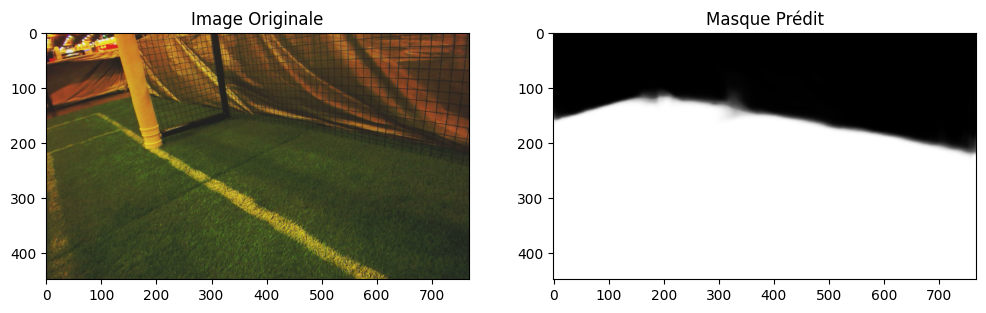

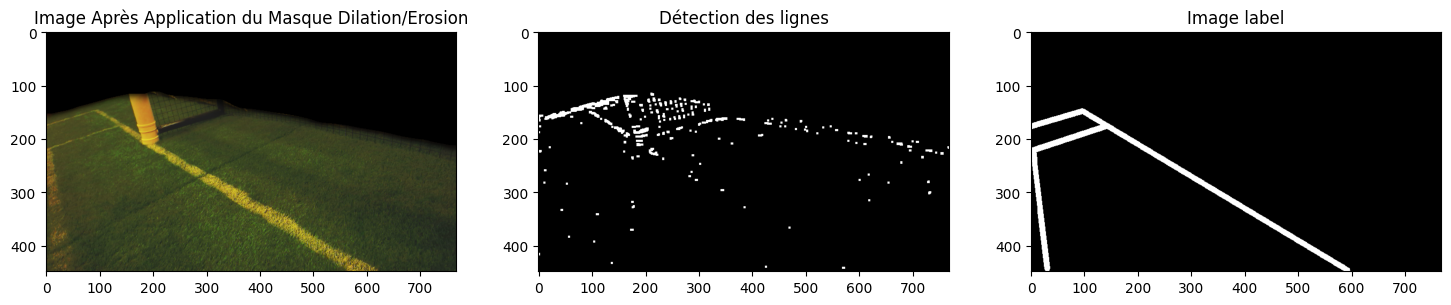

DICE score: 0.09706287287746673


In [3]:
from lines_detection import preprocess

# Charger le modèle
acc_model = tf.keras.models.load_model("acc_model_terrain_"+str(total_params)+"_.h5", custom_objects={'combined_loss': combined_loss, 'dice_metric': dice_metric})
dice_model = tf.keras.models.load_model("dice_model_terrain_"+str(total_params)+"_.h5", custom_objects={'combined_loss': combined_loss, 'dice_metric': dice_metric})

# Charger et préparer l'image
image_path = "../data/log4/27-rgb.png"
image = load_img(image_path, target_size=(448, 768))  # Ajustez la taille selon votre modèle
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
image = image / 255.0

# Prédire le masque
acc_predicted_mask = acc_model.predict(image)
dice_predicted_mask = dice_model.predict(image)
#deepcopy pour pouvoir modifier le masque sans modifier l'original
acc_unthresholded_mask = np.squeeze(acc_predicted_mask[0, ..., 0]).copy()
dice_unthresholded_mask = np.squeeze(dice_predicted_mask[0, ..., 0]).copy()

# Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
# Par exemple, masquer l'image là où le masque est supérieur à un seuil
threshold = 0.25

# Convertir le masque prédit pour les opérations morphologiques
acc_mask_for_morphology = np.squeeze(acc_predicted_mask[0, ..., 0])
dice_mask_for_morphology = np.squeeze(dice_predicted_mask[0, ..., 0])

# Add gaussian blur befor morphological operations
acc_mask_for_morphology = cv2.GaussianBlur(acc_mask_for_morphology, (25, 25), 0)
dice_mask_for_morphology = cv2.GaussianBlur(dice_mask_for_morphology, (25, 25), 0)

# Définir un élément structurant pour les opérations morphologiques
kernel = np.ones((20, 20), np.uint8)

# Appliquer l'érosion et la dilatation
acc_eroded_mask = cv2.erode(acc_mask_for_morphology, kernel, iterations=1)
dice_eroded_mask = cv2.erode(dice_mask_for_morphology, kernel, iterations=1)
acc_dilated_mask = cv2.dilate(acc_eroded_mask, kernel, iterations=1)
dice_dilated_mask = cv2.dilate(dice_eroded_mask, kernel, iterations=1)

# Appliquer le seuil après les opérations morphologiques
acc_dilated_mask[acc_dilated_mask > threshold] = 1
dice_dilated_mask[dice_dilated_mask <= threshold] = 0

# Appliquer le masque morphologiquement amélioré à l'image
acc_masked_image_with_morphology = image[0] * np.expand_dims(acc_dilated_mask, axis=-1)
dice_masked_image_with_morphology = image[0] * np.expand_dims(dice_dilated_mask, axis=-1)


# threshold the mask
acc_predicted_mask[acc_predicted_mask > threshold] = 1
dice_predicted_mask[dice_predicted_mask > threshold] = 1
acc_predicted_mask[acc_predicted_mask <= threshold] = 0
dice_predicted_mask[dice_predicted_mask <= threshold] = 0
acc_masked_image = image[0] * acc_predicted_mask[0]
dice_masked_image = image[0] * dice_predicted_mask[0]

# Afficher l'image originale et l'image masquée
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image Originale")
plt.imshow(image[0])

# afficher predicted_mask
plt.subplot(1, 2, 2)
plt.title("Masque Prédit")
plt.imshow(dice_unthresholded_mask, cmap='gray')
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Image Après Application du Masque Dilation/Erosion")
plt.imshow(dice_masked_image_with_morphology)

inferred_mask = cv2.cvtColor(dice_masked_image_with_morphology, cv2.COLOR_RGB2BGR)
inferred_mask = (inferred_mask * 255).astype(np.uint8)

processed_image = preprocess(inferred_mask)
plt.subplot(1, 3, 2)
plt.title("Détection des lignes")
plt.imshow(processed_image, cmap='gray')

label_image = load_img("labels/log4/27-rgb.png", color_mode='grayscale', target_size=(448, 768))
plt.subplot(1, 3, 3)
plt.title("Image label")
plt.imshow(label_image, cmap='gray')

plt.show()

intersection = np.sum(np.logical_and(processed_image, label_image))
union = np.sum(np.logical_or(processed_image, label_image))
print("DICE score:", (2.0 * intersection) / (union + intersection))



#### Calcul de l'efficacité de la méthode sur l'ensemble des données disponibles 

1/1 [==============================] - 0s 225ms/step
Average dice score: 0.09949201072258566


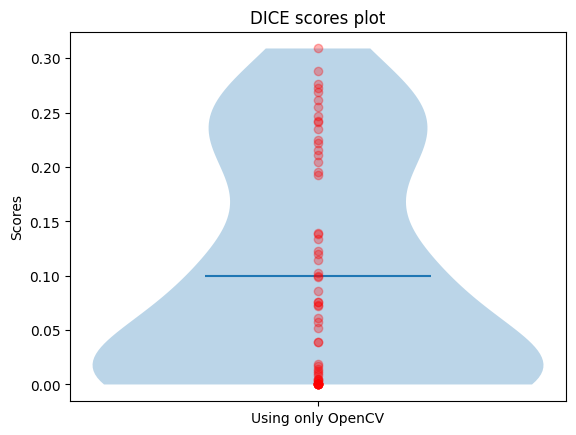

In [16]:
from pathlib import Path
from mask_predictor import MaskPredictor

scores = []

for i in range(1, 5):
    directory = "log" + str(i) + "/"
    files = list(Path("labels/" + directory).glob('*.png'))
    
    for index, file in enumerate(files):
        label_image = load_img("labels/" + directory + file.name, color_mode='grayscale', target_size=(448, 768))

        # Infer mask
        mask_predictor = MaskPredictor('dice_model_terrain_491137_.h5')

        # Traiter l'image et obtenir le masque
        inferred_mask = mask_predictor.process_image("../data/" + directory + file.name, 0.8)
        inferred_mask = cv2.cvtColor(inferred_mask, cv2.COLOR_RGB2BGR)
        inferred_mask = (inferred_mask * 255).astype(np.uint8)

        processed_image = preprocess(inferred_mask)

        intersection = np.sum(np.logical_and(processed_image, label_image))
        union = np.sum(np.logical_or(processed_image, label_image))

        dice = (2.0 * intersection) / (union + intersection)
        scores.append(dice)

print("Average dice score:", sum(scores) / len(scores))

# Create a figure and axis
fig, ax = plt.subplots()

# Create a violin plot
violins = ax.violinplot(scores, showmeans=True, showextrema=False)

# Plot individual points on top of the violins
ax.plot(np.ones_like(scores) * 1, scores, 'ro', alpha=0.3)

# Set labels and title
ax.set_xticks([1])
ax.set_xticklabels(['Using only OpenCV'])
ax.set_ylabel('Scores')
ax.set_title('DICE scores plot')

# Show the plot
plt.show()

### Traitement pour la classification directe des lignes

In [6]:
# Charger le modèle
acc_model = tf.keras.models.load_model("acc_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
dice_model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})

# Charger et préparer l'image
image_path = "videos/log1/039-rgb.png"
image = load_img(image_path, target_size=(448, 768))  # Ajustez la taille selon votre modèle
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
image = image / 255.0

# Prédire le masque
acc_predicted_mask = acc_model.predict(image)
dice_predicted_mask = dice_model.predict(image)
#deepcopy pour pouvoir modifier le masque sans modifier l'original
acc_unthresholded_mask = np.squeeze(acc_predicted_mask[0, ..., 0]).copy()
dice_unthresholded_mask = np.squeeze(dice_predicted_mask[0, ..., 0]).copy()

# Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
# Par exemple, masquer l'image là où le masque est supérieur à un seuil
threshold = 0.25

# threshold the mask
acc_predicted_mask[acc_predicted_mask > threshold] = 1
dice_predicted_mask[dice_predicted_mask > threshold] = 1
acc_predicted_mask[acc_predicted_mask <= threshold] = 0
dice_predicted_mask[dice_predicted_mask <= threshold] = 0
acc_masked_image = image[0] * acc_predicted_mask[0]
dice_masked_image = image[0] * dice_predicted_mask[0]

# Afficher l'image originale et l'image masquée
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Image Originale")
plt.imshow(image[0])

# afficher predicted_mask
plt.subplot(1, 3, 2)
plt.title("Masquage Acc")
plt.imshow(acc_masked_image)

plt.subplot(1, 3, 3)
plt.title("Masquage Dice")
plt.imshow(dice_masked_image)
plt.show()

OSError: No file or directory found at acc_model_line_491137_.h5

### Traitement Vidéo

In [90]:
# Charger le modèle
model = tf.keras.models.load_model("dice_model_terrain_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
#model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})


# Ouvrir la vidéo
video_path = 'videos/log1.mp4'
cap = cv2.VideoCapture(video_path)
threshold = 0.6
kernel = np.ones((20, 20), np.uint8)


# Préparer l'enregistrement de la vidéo (si nécessaire)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (768, 448))


# Lire la vidéo frame par frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir en RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Redimensionner et normaliser la frame
    resized_frame = cv2.resize(frame, (768, 448))
    normalized_frame = resized_frame / 255.0
    normalized_frame = np.expand_dims(normalized_frame, axis=0)

    

    # Prédire le masque
    predicted_mask = model.predict(normalized_frame)

    # Appliquer les opérations morphologiques
    mask_for_morphology = np.squeeze(predicted_mask[0, ..., 0])
    # Add gaussian blur befor morphological operations
    """ mask_for_morphology = cv2.GaussianBlur(mask_for_morphology, (25, 25), 0)
    mask_for_morphology = cv2.erode(mask_for_morphology, kernel, iterations=1)
    mask_for_morphology = cv2.dilate(mask_for_morphology, kernel, iterations=1) """
    mask_for_morphology[mask_for_morphology > threshold] = 1
    mask_for_morphology[mask_for_morphology <= threshold] = 0

    # Appliquer le masque à la frame pour que les pixels blancs du masque soient rouges dans la frame
    masked_frame = resized_frame.copy()

    masked_frame[mask_for_morphology == 0] = [0, 0, 0] # terrain
    #masked_frame[mask_for_morphology == 1] = [255, 0, 0] # line

    # Convertir en format BGR pour OpenCV et remettre à l'échelle
    masked_frame = masked_frame.astype('uint8')  # Remettre à l'échelle et convertir en uint8

    # Convertir en BGR
    masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_RGB2BGR)

    # Afficher la frame masquée (ou enregistrer)
    cv2.imshow('Frame', masked_frame)
    #out.write(masked_frame)

    # Quitter avec 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 14ms/step


: 